In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Importamos los módulos de Python que utilizaremos
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn import linear_model
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Introducción
A lo largo de este documento, vamos a considerar un conjunto de datos sobre el que trataremos de construir modelos de aprendizaje supervisado para predecir el valor de una variable continua, es decir, modelos de **regresión**. Primero presentaremos el caso de uso, analizaremos los datos y pasaremos a considerar distintos algoritmos de aprendizaje supervisado.

La estructura del documento es como sigue:

2. Caso de uso
3. Random Forest
4. XGBoost
5. Regresión lineal
6. Comparación entre modelos

# Caso de uso

Considerarmos un conjunto de datos de precios de coches de segunda mano obtenido de Kaggle:

* Enlace: https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes

Aunque en el nombre del enlace podéis ver _Ford_ y _Mercedes_, el enlace contiene datos de otras marcas. Cada uno de los archivos contiene datos de una marca en particular (audi.csv, toyota.csv, etc.). Aquí consideraremos únicamente los coches Audi.

In [ ]:
# leemos el archivo
df = pd.read_csv("audi.csv")

## Análisis exploratorio

Siempre que cargamos una tabla de datos, conviene echarle un vistazo rápido.

In [ ]:
print(df.shape)

(10668, 9)


Como vemos, tenemos:
* 10668 filas
* 9 columnas

In [ ]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

Veamos ahora la cabecera de la tabla de datos:

In [ ]:
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
5,A1,2016,13900,Automatic,32260,Petrol,30,58.9,1.4
6,A6,2016,13250,Automatic,76788,Diesel,30,61.4,2.0
7,A4,2016,11750,Manual,75185,Diesel,20,70.6,2.0
8,A3,2015,10200,Manual,46112,Petrol,20,60.1,1.4
9,A1,2016,12000,Manual,22451,Petrol,30,55.4,1.4


Como vemos, tenemos 9 columnas:
* "model": Modelo de Audi.
* "year": Año en el que se vendió el coche originalmente.
* "price": Precio al que se revendió en libras esterlinas. Esto es la variable __objetivo__.
* "transmission": Tipo de cambio de marchas ("Manual", "Automatic" o "Semi-Auto").
* "mileage": Millas recorridas por el coche.
* "fuelType": Tipo de combustible ("Petrol", "Diesel" o "Hybrid").
* "tax": Impuesto de circulación en libras esterlinas.
* "mpg": Distancia recorrida en función del combustiile consumido en millas por galón.
* "enginSize": Tamaño del motor en litros.

Como en el caso de clasificación, conviene estudiar en más profundidad cada **columna** o **variable**. Empezamos por las variables independientes y luego analizaremos la variable objetivo "price".

### Valores perdidos

Veamos ahora valores nulos o perdidos:

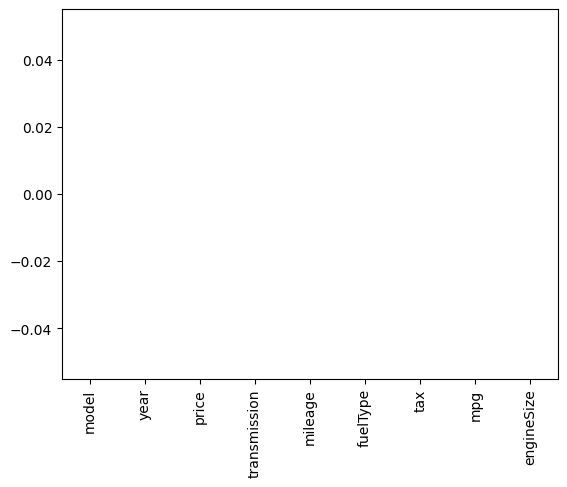

In [ ]:
df.isnull().sum().plot(kind="bar");

En este caso todas las columnas están informadas por completo.

### Variables numéricas

In [ ]:
for x in ["year", "mileage", "tax", "mpg", "engineSize"]:
  x=df['price'].corr(df[x])
  print(x)

0.5925814569762284
-0.535357095232291
0.35615698997023626
-0.6003343844160695
0.5912616428923317


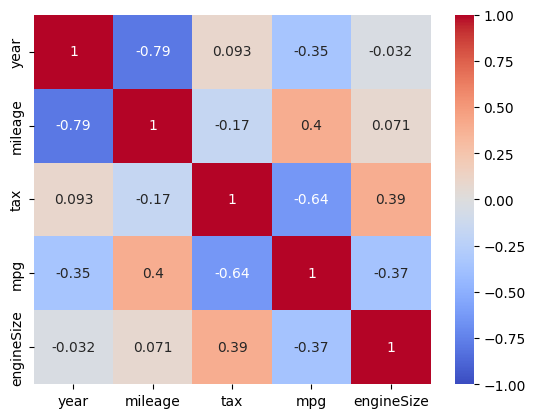

In [ ]:
df[list_numerical_variables].corr()
sns.heatmap(df[list_numerical_variables].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);

Veamos ahora con las variables numéricas. Construimos sus histogramas y las correlaciones mutuas.

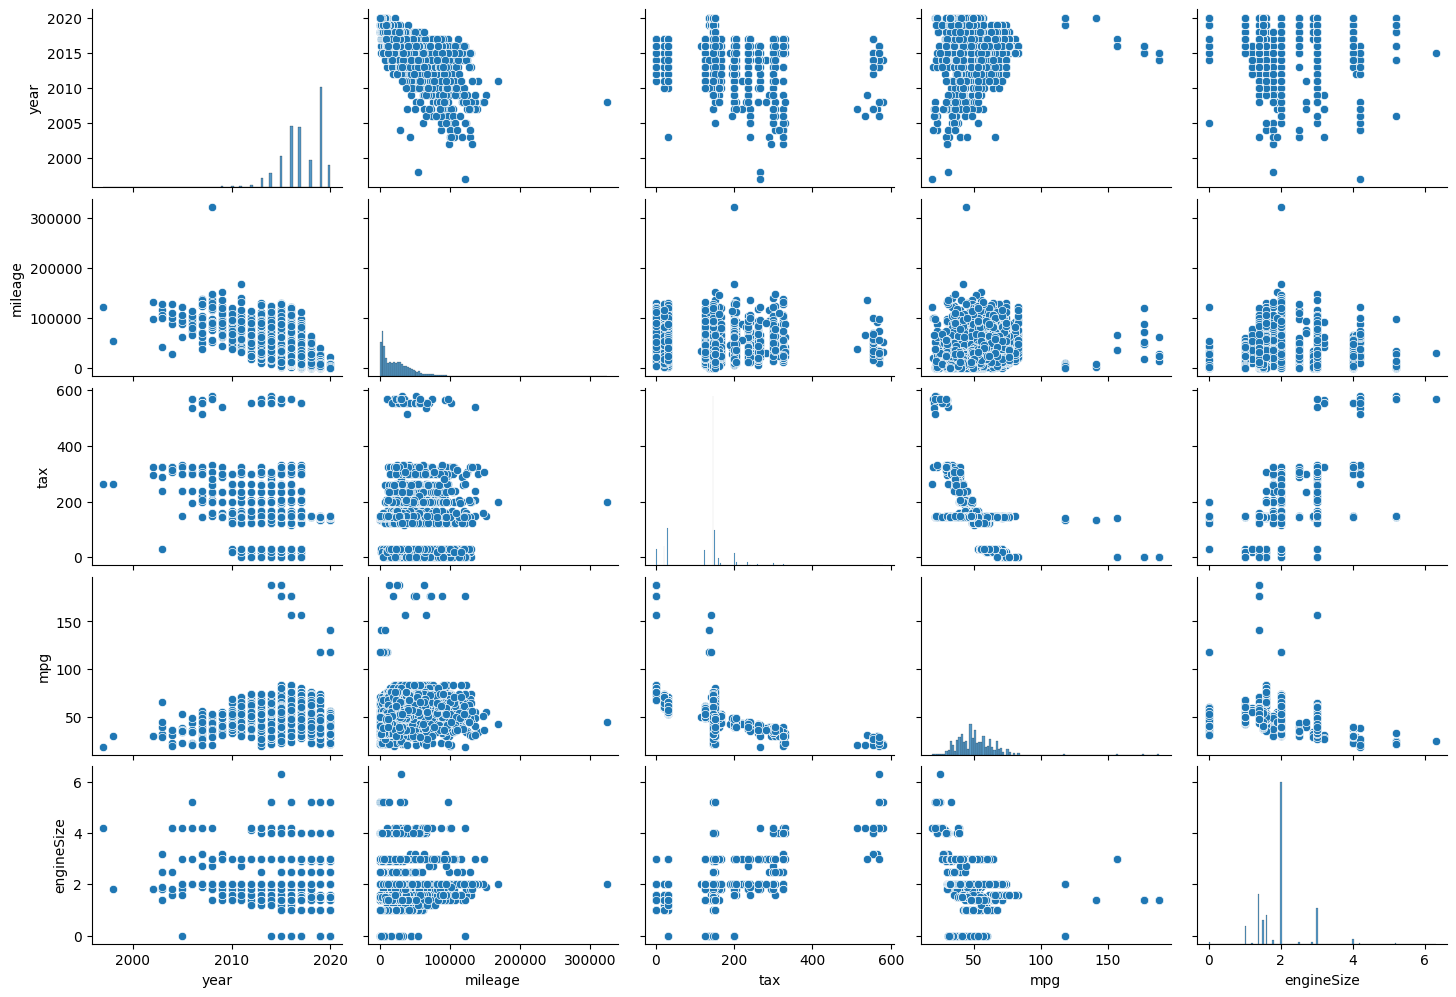

In [ ]:
list_numerical_variables = ["year", "mileage", "tax", "mpg", "engineSize"]
fig_pairplot = sns.pairplot(df[list_numerical_variables])
fig_pairplot.fig.set_size_inches(15, 10)

Recordemos que la función sns.pairplot() genera una cuadrícula de figuras con histogramas de las variables en las gráficas diagonales y unas variables en función de las otras en las gráficas de fuera de la diagonal.

Como en el caso de clasificación, las variables tienen distribuciones de valores razonables, lo cual es positivo.

Por otra parte, vemos que algunas variables muestran correlación entre sí. Por ejemplo, cuanto mayor es el año, menos es la distancia recorrida por el coche, como es lógico. Esto nos sugiere que podemos hacer PCA con "year" y "mileage". Además, el impuesto de circulación muestra una correlación dereciente con el consumo, el cual, a su vez, también se relaciona con el tamaño del motor. Es por esto que también podemos probar a hacer un PCA con "tax", "mpg" y "engineSize".

Probemos a construir el PCA de "year" y "mileage" y el de "tax", "mpg" y "engineSize". Previamente, definimos la función do_pca para construir PCA y pca_importance para representar gráficamente la calidad de la descomposición PCA.

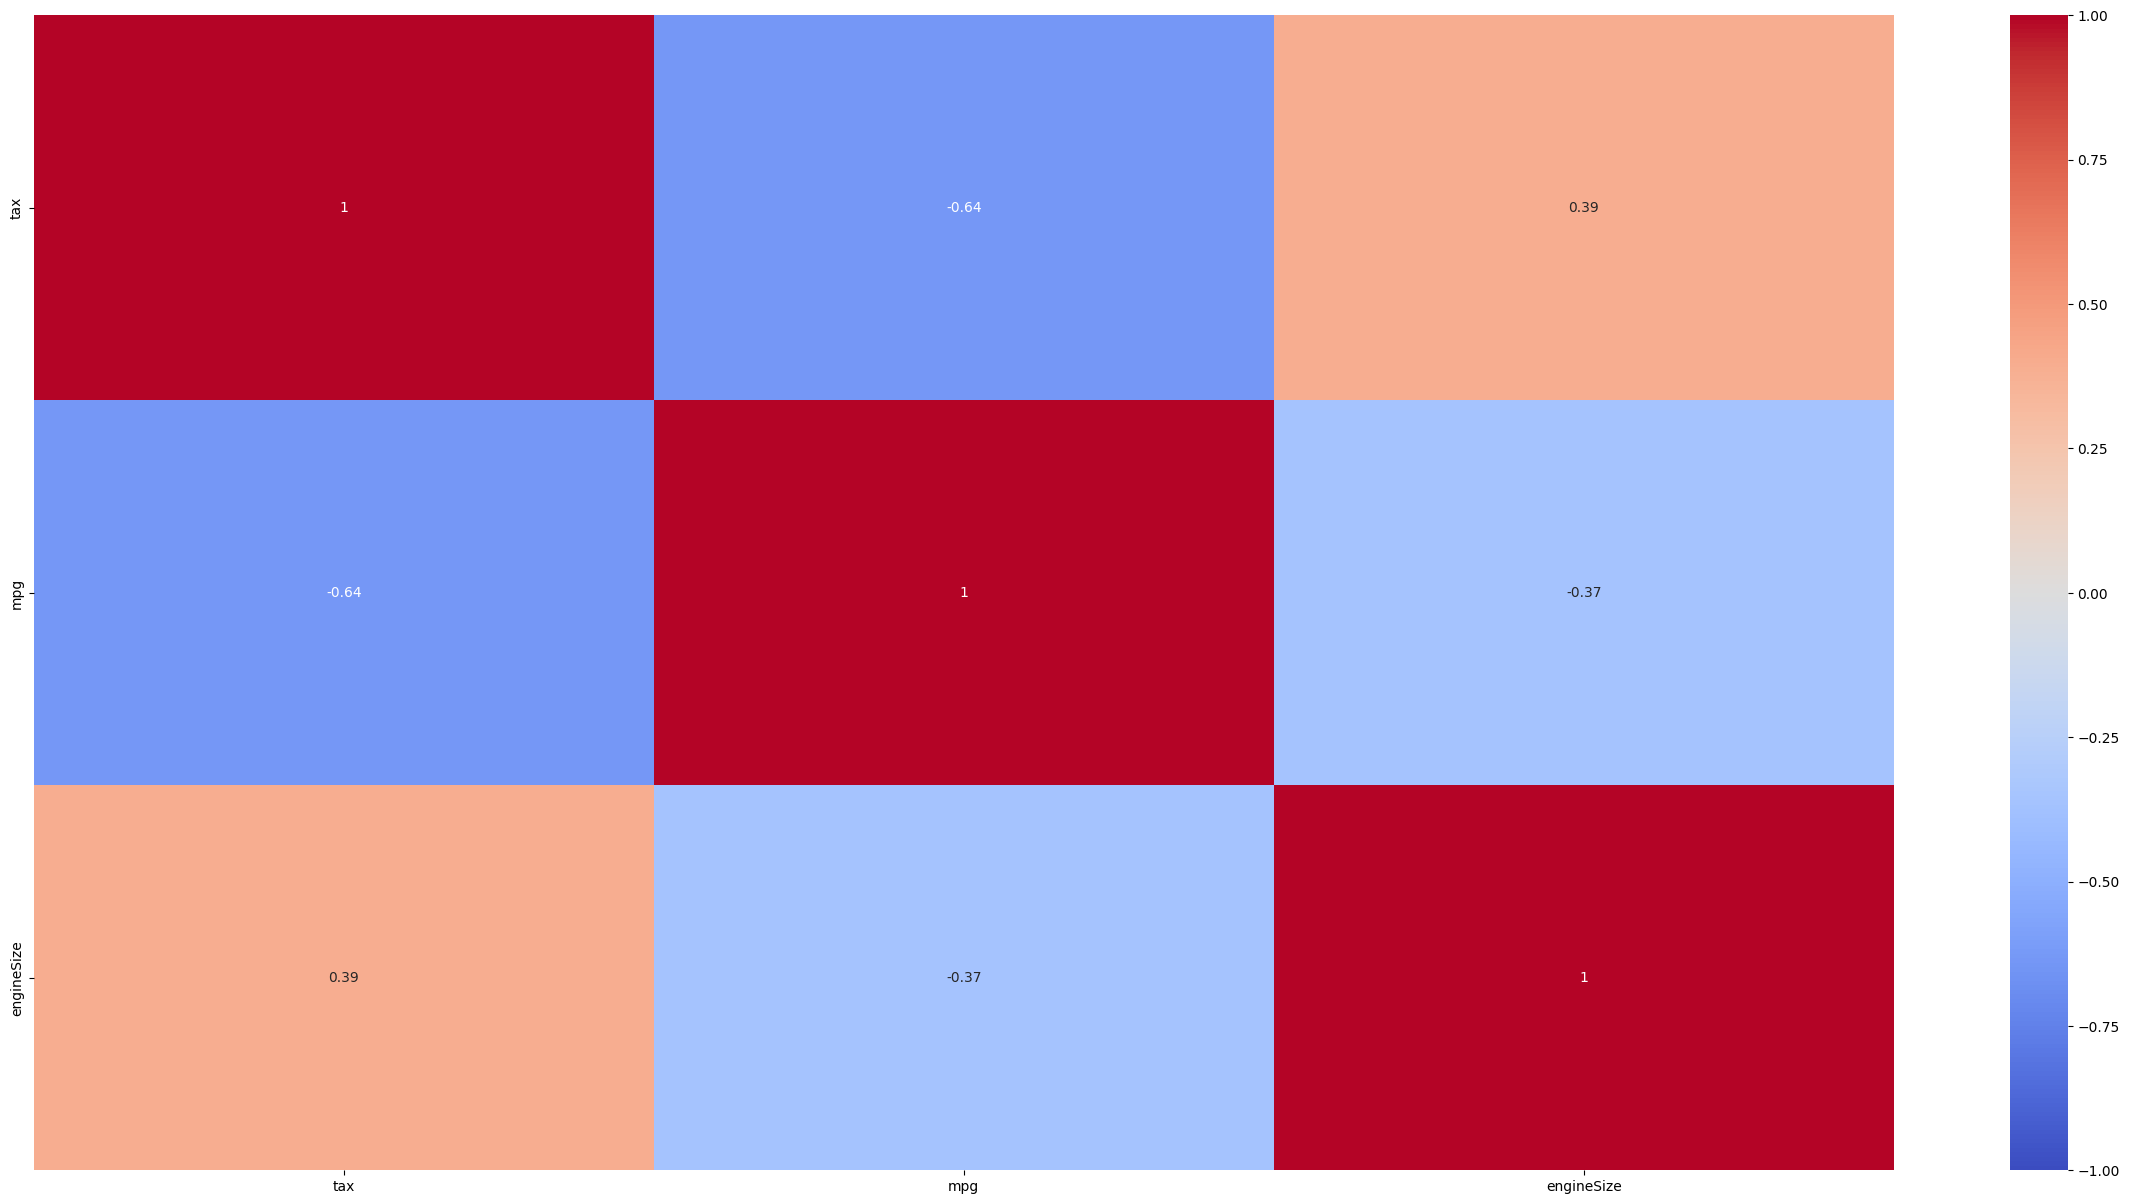

In [ ]:
prueba_corr = df[["tax", "mpg", "engineSize"]].corr()
plt.figure(figsize=(30, 15))
sns.heatmap(prueba_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
def do_pca(X, n):
    sc = StandardScaler()
    X = sc.fit_transform(X)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


def pca_importance(pca):
    components = pca.components_  # Axis of maximum variation
    n = len(components)
    x = np.arange(n)
    values = pca.explained_variance_ratio_ * 100
    acvalues = np.cumsum(values)

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.bar(x + 1, values)
    ax.plot(x + 1, acvalues)
    for i in x:
        ax.annotate("{}%".format(round(values[i], 2)), (i + 1 -.1, values[i]),
                    fontsize=15)
        ax.annotate("{}%".format(round(acvalues[i], 2)), (i + 1 -.1, acvalues[i]),
                    fontsize=15)
    ax.set_xlabel("Número de componentes")
    ax.set_ylabel("Variabilidad (%)")

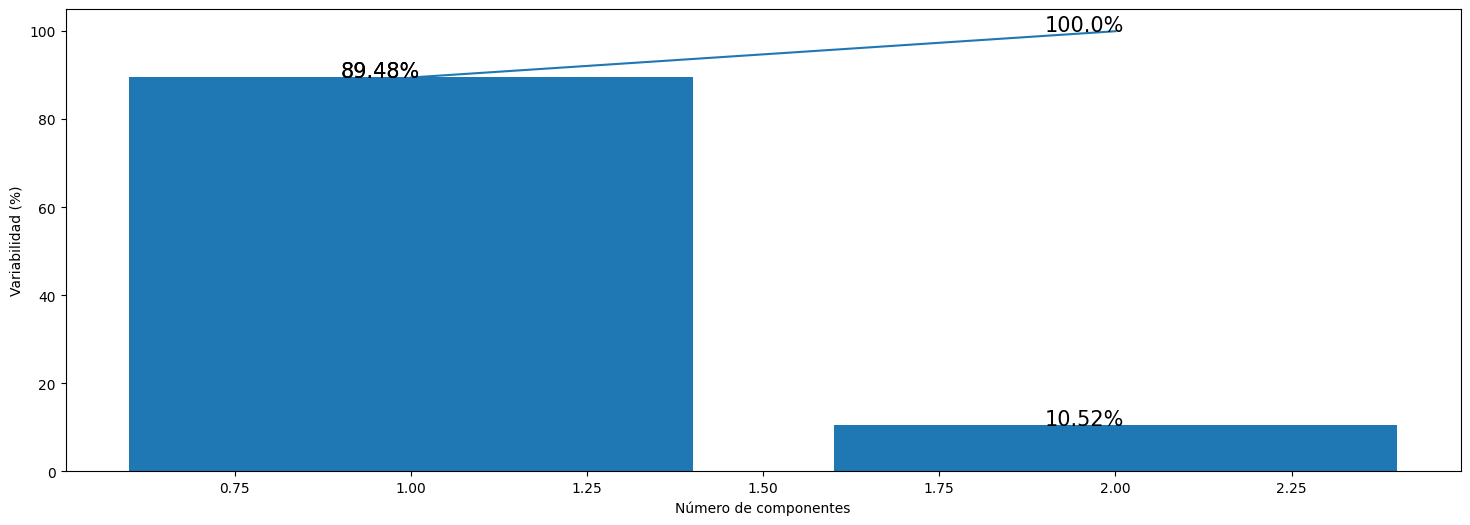

In [ ]:
pca_year_mileage, X_pca = do_pca(df[["year", "mileage"]], 2)
pca_importance(pca_year_mileage)


Como vemos, quedándonos con solo una componente a partir de "year" y "mileage", explicamos casi un 90% de la variabilidad. Es por esto que es probable que ayude al modelo quedarnos con PCA de una sola componente en vez de con las dos variables por separado.

Veamos qué tal funciona con "tax", "mpg" y "engieSize":

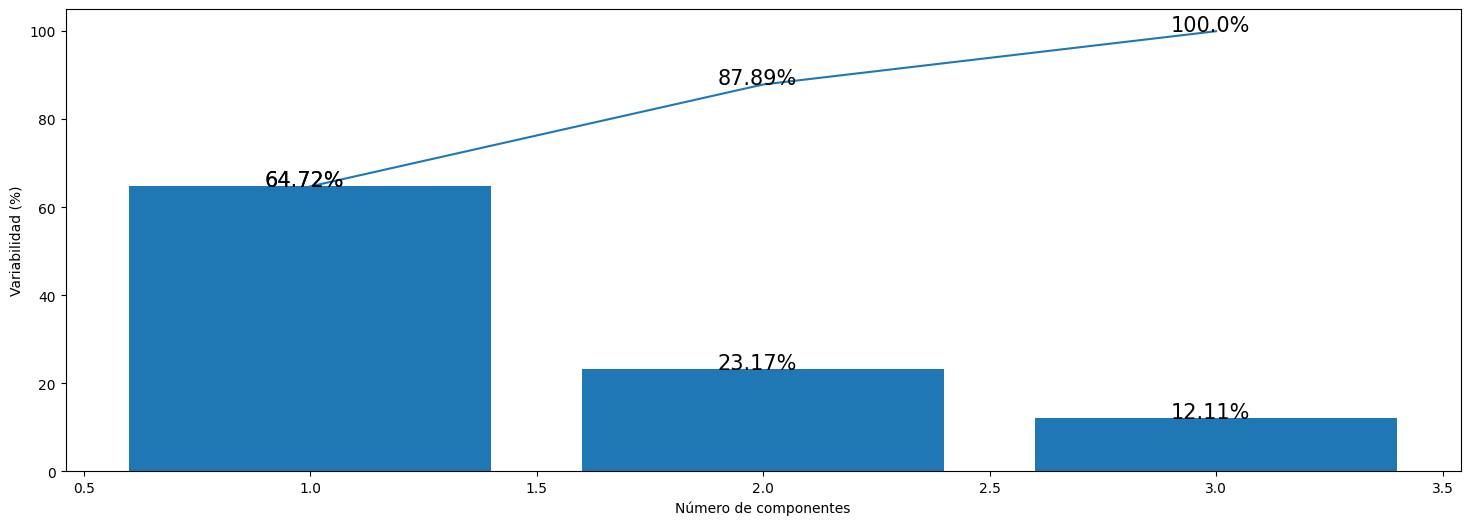

In [ ]:
pca_year_mileage, X_pca = do_pca(df[["tax", "mpg", "engineSize"]], 3)
pca_importance(pca_year_mileage)

Ya con una componente recuperamos un 65% de la varibilidad y con dos un 88%, así que es posible que esta reducción de la dimensionalidad ayude a los modelos.

### Variables categóricas

Nuestras variables categóricas son:
* "model"
* "transmission"
* "fuelType"

Veamos qué valores toman y cómo se distribuyen estos:

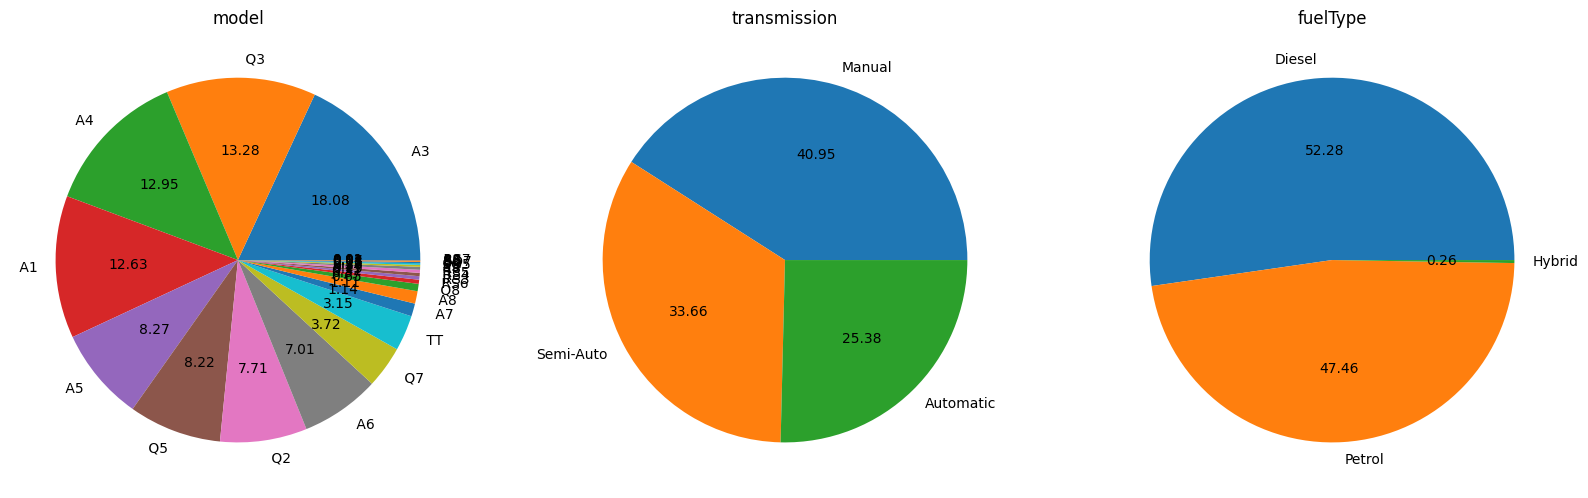

In [ ]:
list_categorical_variables = ["model", "transmission", "fuelType"]
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 15)
df["model"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[0], title="model");
df["transmission"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[1], title="transmission");
df["fuelType"].value_counts().rename("").plot.pie(autopct='%.2f', ax=axes[2], title="fuelType");

La variable "transmission" tiene una distribución perfecta de valores.

Por su parte, la variable "fuelType" es similar a "gender" en el problema de clasificación: tiene dos valores muy frecuentes ("Diesel" y "Petrol") y un tercero que es muy poco frecuente ("Hybrid"), de tal forma que los modelos podrán encontrar correlaciones entre "price" y "Diesel" y "Petrol", mientras que no veremos ninguna relación "Hybrid" y nuestra variable objetivo.

Finalmente, "model" sí que tiene mucha variabilidad, de tal forma que es posible que haya que darle un tratamiento especial a la hora de hacer ingeniería de variables.

### Variable objetivo
Nuestra variable objetivo, "price", es una variable numérica. Empezaremos por analizar la variable en sí, para luego ver cómo se relaciona con nuestras variables independientes.

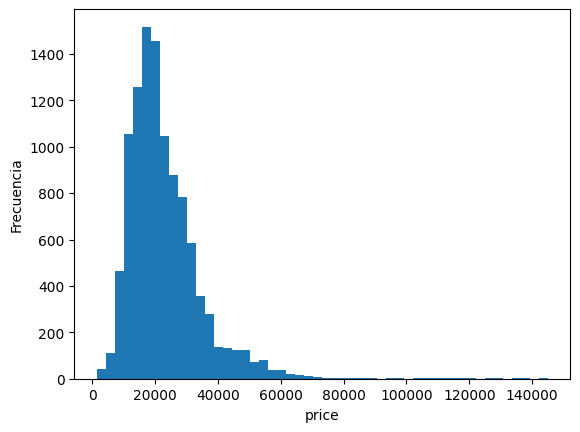

In [ ]:
ax = df.price.plot(kind="hist", bins=50);
ax.set_xlabel("price");
ax.set_ylabel("Frecuencia");

Vemos que la variable objetivo tiene una distribución con buen comportamiento, lo cual es positivo para los algoritmos de aprendizaje supervisado.

También podemos estudiar la correlación entre la variable objetivo y las distintas variables. Empezamos por las numéricas. Mostramos el precio ("price") como función de nuestras variables numéricas:

In [ ]:
list_numerical_variables

['year', 'mileage', 'tax', 'mpg', 'engineSize']

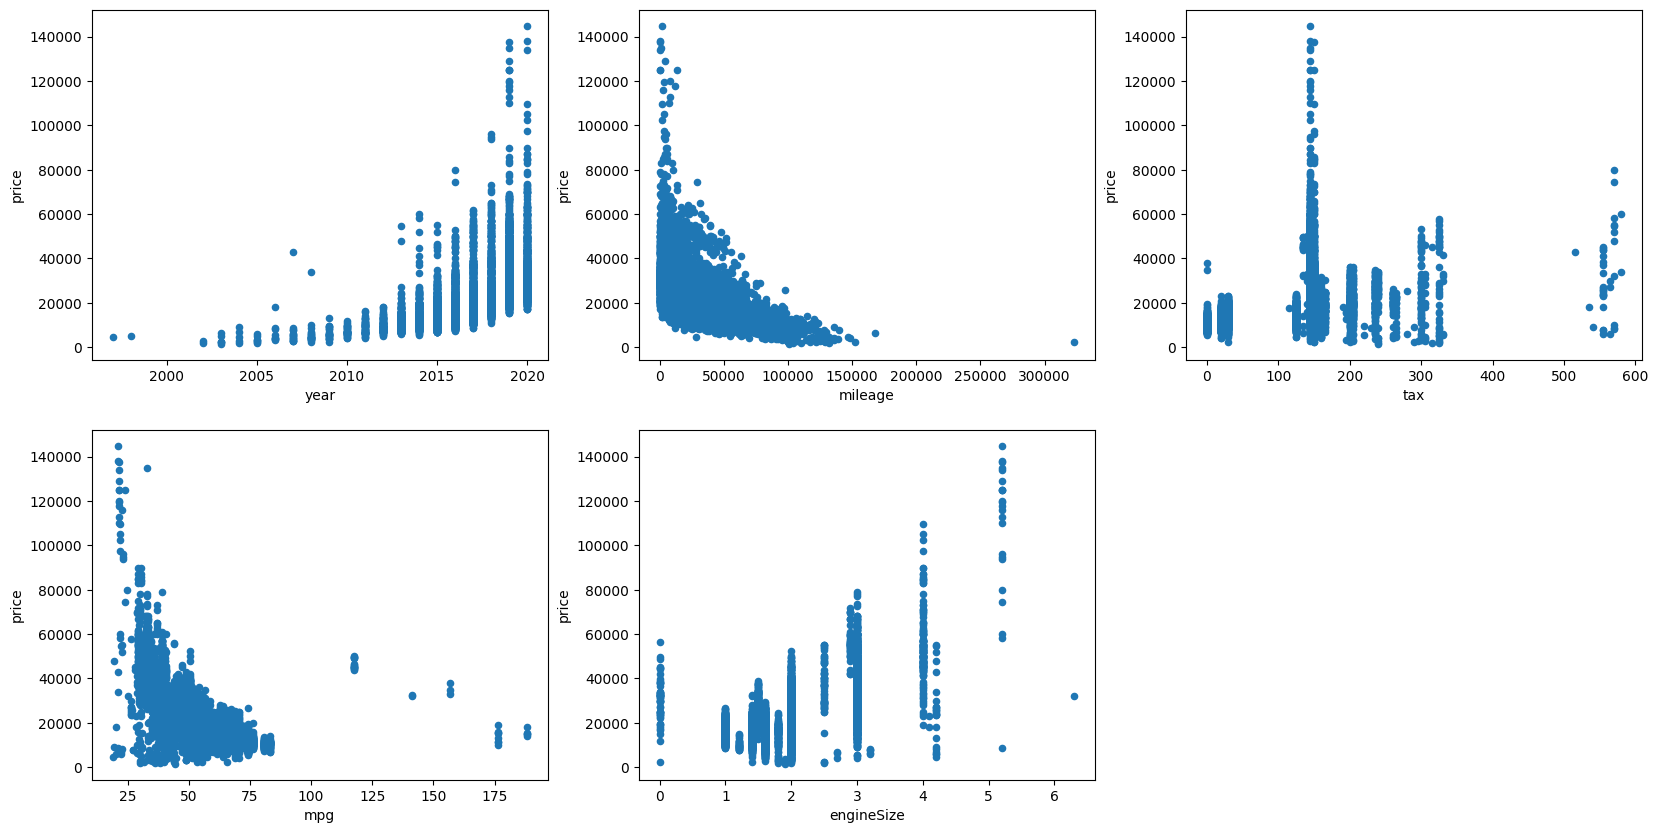

In [ ]:
fig, axes = plt.subplots(2, 3)
axes[-1, -1].axis('off')
fig.set_size_inches(20, 10)
df.plot(kind="scatter", ax=axes[0, 0], x="year", y="price");
df.plot(kind="scatter", ax=axes[0, 1], x="mileage", y="price");
df.plot(kind="scatter", ax=axes[0, 2], x="tax", y="price");
df.plot(kind="scatter", ax=axes[1, 0], x="mpg", y="price");
df.plot(kind="scatter", ax=axes[1, 1], x="engineSize", y="price");

A priori, parece claro que todas las variables tienen una clara correlación con la variable objetivo:

* Cuanto más reciente es el coche, mayor es el precio.
* Cuanto mayor es la distancia recorrida por el coche, menor es el precio.
* Cuanto mayor es el impuesto de circulación, el coche tiende a ser más caro, si bien hay un pico muy grande en torno a 150 libras.
* A mayor "mpg", menor precio.
* A mayor tamaño del motor, mayor precio.

Grosso modo, vemos que todas las variables están correlacionadas con la variable objetivo, así que no podemos prescindir de ninguna de ellas a priori.

Vayamos ahora con la relación con las categóricas, mostrando cuál es el precio medio para cada valor de las categorías.

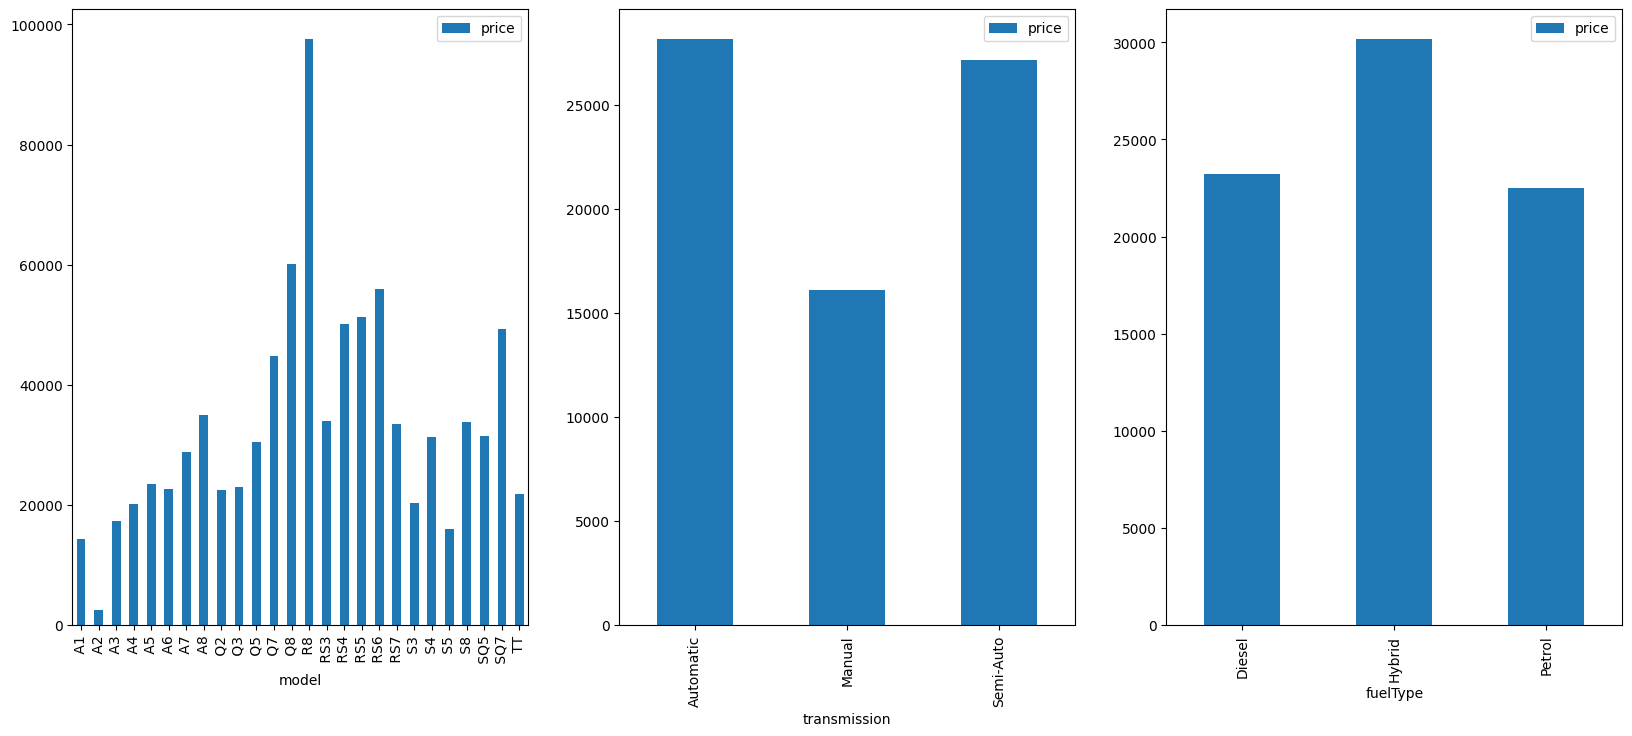

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 8)
df[["model", "price"]].groupby(by="model").mean().plot(kind="bar", ax=axes[0]);
df[["transmission", "price"]].groupby(by="transmission").mean().plot(kind="bar", ax=axes[1]);
df[["fuelType", "price"]].groupby(by="fuelType").mean().plot(kind="bar", ax=axes[2]);

Vemos que "model" correlaciona muy fuertemente con el precio.

Por su parte, los coches con "transmission" "Manual" tienden a ser más baratos que los coches con cambio "Automatic" y "Semi-Auto".

Finalmente, los coches con "fuelType" tipo "Diesel" y "Petrol" tienen precios similares, mientras que los "Hybrid" tienden a ser más caros. Sin embargo, notar que esta últia categoría está muy poco frecuente en el conjunto de datos, así que puede que esta variable tenga poco impacto en los modelos.

## Separación en entrenamiento y test
Separamos nuestros datos en entrenamiento y test. Notar que esto lo hacemos antes de realizar ninguna transformación sobre nuestros datos, ya que, de lo contrario, estaríamos utilizando información de nuestro conjunto de test para manipular el conjunto sobre el que entrenaremos los datos, lo que implicaría que estaríamos cometiendo "leakage".

Tratamos por separado las columnas que harán como predictores y la variable objetivo en X e y.

In [ ]:
X = df.drop(columns=["price"], inplace=False)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=None, random_state=0)

Separamos solo en entrenamiento y test, pero haremos validación cruzada sobre nuestro conjunto de entrenamiento X_train.

## Ingeniería de variables

### Variables categóricas

Consideramos *one-hot encoding* para "transmission" y "fuelType". Para "model" consideramos otra categorización.

#### *One-hot encoding*

In [ ]:
list_columns_to_ohe = ["transmission", "fuelType"]

ohencoder = ce.OneHotEncoder(cols=list_columns_to_ohe, use_cat_names=True)

X_train = ohencoder.fit_transform(X_train)
X_test = ohencoder.transform(X_test)

Igual que hicimos en el documento de clasificación, veamos cómo han quedado ahora estas variables:

In [ ]:
X_train.filter(regex="^transmission_").head()

,transmission_Manual,transmission_Automatic,transmission_Semi-Auto
4929,1,0,0
9420,0,1,0
8756,0,0,1
9758,1,0,0
9341,0,1,0


In [ ]:
X_train.filter(regex="^fuelType_").head()

,fuelType_Petrol,fuelType_Diesel,fuelType_Hybrid
4929,1,0,0
9420,1,0,0
8756,1,0,0
9758,1,0,0
9341,0,1,0


#### "Model": codificación alternativa

La columna "model" muchos más valores úicos:

In [ ]:
print(len(df.model.unique()))

26


Esto haría que tuviéramos 26 columnas diferentes si hiciéramos *one-hot encoding*. Es por esto que consideramos otro tipo de codificación en la cual transformaremos cada valor de "model" en un número. Esto lo que hará será dotar a la variable de una ordenación concreta. La clave es ver si esa ordenación tiene sentido.

Consideramos *count encoding*, es decir, transformar cada valor de "model" en el número de veces que aparece tal valor en el conjunto de entrenamiento.

In [ ]:
encoder = ce.CountEncoder(cols="model")
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

Veamos cómo ha quedado la columna:

In [ ]:
X_train.model.head(10)

,model
4929,1075
9420,663
8756,1075
9758,259
9341,1554
3170,1554
237,599
179,1109
4233,694
7019,1075


Como vemos, ahora tiene números y no categorías. Como hemos comentado, se trata de una sustitución de cada categoría por el número de veces que aparece. De hecho, en el objeto "encoder" podemos ver cómo es esa transformación:

In [ ]:
pd.DataFrame(encoder.mapping).reset_index(drop=False).rename(columns={"index": "model", "model": "veces"})

ValueError: cannot insert model, already exists

Esto significa que A3 aparece 1554 veces, por lo que sustituimos su valor por 1554; Q3 aparece 1128 veces, así que cambiamos Q3 por 1128, etc.

Veamos ahora si esta ordenación le puede sentar bien al modelo. Para ello, mostramos "price" en función del recién transformado "model":

In [ ]:
pd.concat(objs=[X_train, y_train], axis=1).plot(kind="scatter", x="model", y="price");

¡No tiene mala pinta! Vemos que, típicamente, cuanto mayor es "model", lo cual indica que ese modelo de coche aparece con más frecuencia en nuestra tabla, menor es el precio. En cierto modo esto tiene sentido: los coches más comunes, los que más se venden, tienden a tener precios más bajos que los coches más exclusivos.

Finalmente, ordenamos las columnas por orden alfabético:

In [ ]:
list_all_columns = X_train.columns.tolist()
list_all_columns.sort()
X_train = X_train[list_all_columns]
X_test = X_test[list_all_columns]

## Validación cruzada

Utilizaremos validación cruzada para ajustar nuestros modelos. Es por esto que creamos shuffle_split, que es el objeto que necesitamos utilizar para hacer la validación cruzada. Sin entrar en más detalles, este objeto contiene 5 copias (porque usamos n_spits=5) de nuestro conjunto de entrenamiento, generando en cada una de ellas una división entre lo que se usará para entrenar y lo que se usará para validar.

In [ ]:
shuffle_split = ShuffleSplit(n_splits=5, random_state=0)

# Random Forest

Comenzamos con el Random Forest.

Empezamos por definir la malla de hiperparámetros. Ya los vimos en la parte de clasificación, pero no está de más recordarlos, además de que algunos toman valores diferentes al tratarse de un problema de regresión:
* "n_estimators" es el número de árboles a considerar.
* "criterion" es la métrica considerada para hacer divisiones en el árbol. Al ser regresión, puede ser "mse" (*mean-squared error* o error cuadrático medio) o "mae" (*mean-absolute error* o error absoluto medio).
* "max_depth" es la profundidad de los árboles.
* "max_features" es el número de columnas a considerar en cada división. Si es None, entonces se consideran todas.
* "boostrap" es una variable lógica que indica si hacemos *bootstrapping* (True) o no (False).
* "oob_score" es, de nuevo, una variable lógica. Si vale True, entonces el Random Forest nos da el error que cometemos en la parte del conjunto de entrenamiento que queda fuera del *bootstrapping*.
* "max_samples" indica el número de filas consideradas cuando "bootstrap" es True; si es un entero, es el número de filas en sí, si es un número real, entonces es el ratio de filas a tomar.

Podéis venir aquí https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html para saber más al respecto.

In [ ]:
dict_params = {"n_estimators": [200, 250, 300],
               "max_depth": [15, 20, 25],
               "criterion": ["squared_error"],
               "max_features": [None],
               "bootstrap": [True],
               "oob_score": [True],
               "max_samples": [0.6]
              }

Usaremos validación cruzada con búsqueda en malla de hiperparámetros. La métrica de validación es "neg_mean_absolute_error", que es el *mae* con un signo menos delante. Se le pone el signo menos porque el parámetro "scoring" de la función GridSearchCV tiene que ser una función a maximizar.

In [ ]:
model_RF = GridSearchCV(estimator=RandomForestRegressor(random_state=42997296),
                        param_grid=dict_params,
                        cv=shuffle_split,
                        refit=True,
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        scoring="neg_mean_absolute_error"
                        )

Entrenamos:

In [ ]:
list_columns_to_train_RF = X_train.columns.tolist()
list_columns_to_train_RF.sort()
model_RF.fit(X_train[list_columns_to_train_RF], y_train)

Los mejores hiperparámetros son:

In [ ]:
model_RF.best_params_

## Análisis de resultados en el conjunto de entrenamiento

Analicemos los resultados en el conjunto de entrenamiento. Empezamos por el *mae*:

In [ ]:
y_train_preds_RF = model_RF.predict(X_train[list_columns_to_train_RF])

mean_absolute_error(y_train, y_train_preds_RF)

Este número de por sí nos dice poco. Para darle sentido, comparémoslo con la mediana del precio:

In [ ]:
print("El ratio entre el mae y la mediana del precio es: {}.".format(mean_absolute_error(y_train, y_train_preds_RF) / y_train.median()))

Podemos decir que estamos cometiendo un error de un 5%. Vayamos ahora con el error cuadrático medio. En este caso, para darle sentido a la cantidad, tomaremos su raíz cuadrada y la compararemos con la media del precio:

In [ ]:
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(mean_squared_error(y_train, y_train_preds_RF)) / y_train.mean()))

Con esta métrica obtenemos un porcentaje de error similar al anterior. Veamos el coficiente $R^2$. Lo definimos primero:

$$
R^2 = 1 - \frac{\sum_{i=1}^m(y_i - \hat{y}_i)^2}{\sum_{i=1}^m(y_i - \bar{y})^2}
$$

Se trata de 1 menos el cociente entre la suma de la diferencia cuadrática entre $y_i$ (en nuestro caso, los precios) e $\hat{y}_i$ (las predicciones de nuestro modelo) dividido entre la diferencia cuadrática entre $y_i$ (en nuestro caso, los precios) e $\hat{y}$ (el precio medio en nuestro caso).

Dado un modelo perfecto, en el cual $y_i=\hat{y}_i$ para todas las observaciones, este coeficiente vale 1. En el caso de un modelo equivalente a, simplemente, asignar como predicción la media de la variable objetivo $\bar{y}$, entonces $R^2$ vale 0. Por tanto, cuanto más cerca de 1, mejor es el modelo, mientras que valores de $R^2$ próximos a 0 indican que el modelo es poco mejor que tomar directamente la media.

Notar que puede haber modelos que sean incluso peores que predecir directamente la media, en cuyo caso $R^2$ es negativo.

In [ ]:
r2_score(y_train, y_train_preds_RF)

Vemos que su valor está muy cerca de 1, así que el modelo funciona muy bien en el conjunto de entrenamiento.

Veamos ahora cuál es nuestra mejor métrica en validación cruzada:

In [ ]:
print("mae en validación cruzada es: {}".format(-(model_RF.cv_results_["mean_test_score"].max())))

Se trata de un *mae* similar al de entrenamiento, sobre todo si lo comparamos con la mediana de los precios.

Mostramos las predicciones en función del valor real de "price" en el conjunto de entrenamiento. Adjuntamos a la gráfica una línea recta que indica lo que tendrían que valer las predicciones para que el modelo fuera perfecto.

In [ ]:
fig, ax = plt.subplots(1, 1)
pd.DataFrame({"price": y_train, "price_pred": y_train_preds_RF}).plot(kind="scatter",
                                                                      x="price",
                                                                      y="price_pred",
                                                                      ax=ax);
pd.DataFrame({"price": y_train, "price_2": y_train}).sort_values(by="price").plot(x="price", y="price_2", ax=ax, color="red", legend=False);


Como vemos, tiene muy buen aspecto: todas las predicciones se encuentran muy cerca de la línea recta a simple vista. Ahora bien, tanto esta gráfica como el coeficiente $R^2$ lo que nos indican es cómo de cerca están las predicciones de sus valores reales, pero no nos dan información de posibles sesgos, como desviaciones típicas al alza o a la baja en función del rango de precios. Para ilustrar esto, dibujamos ahora las diferencias entre las predicciones y los valores reales para los distintos rangos de precios:

In [ ]:
fig, ax = plt.subplots(1, 1)

df_diff = pd.DataFrame({"price": y_train, "diff": y_train_preds_RF - y_train})

df_diff.plot(kind="scatter",
             x="price",
             y="diff",
             ax=ax);

pd.DataFrame({"price": y_train, "perfect_model": 0}).sort_values(by="price").plot(x="price", y="perfect_model", ax=ax, color="red", legend=False);


Vemos que el error tiende a distribuirse de forma bastante aleatoria en todos los rangos de precios. Dibujamos el histograma de las diferencias:

In [ ]:
ax = df_diff["diff"].plot(kind="hist", bins=40);
ax.set_xlabel("diff");
ax.set_ylabel("Frecuencia");

Sin entrar en mucho detalle, el error se distribuye de forma tipo gaussiana en torno a 0. Esto, unido a los buenos números en *mae*, *mse* y $R^2$, nos lleva a la conclusión de que, al menos en el conjunto de entrenamiento, las predicciones se parecen mucho a los valores reales.

## Análisis de resultados en el conjunto de test

Analizamos ahora los resultados en test. Empezamos por varias métricas (*mae* y *mse* escalados como antes y el coeficiente $R^2$):

In [ ]:
def print_metrics(model, X, y):
    y_preds = model.predict(X)
    print("El ratio entre el mae y la mediana del precio es: {}.".format(mean_absolute_error(y, y_preds) / y.median()))
    print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(mean_squared_error(y, y_preds)) / y.mean()))
    print("El coeficiente R2 es: {}".format(r2_score(y, y_preds)))

In [ ]:
y_test_preds_RF = model_RF.predict(X_test)

print_metrics(model_RF, X_test, y_test)

Hemos bajado algo la precisión mirando las distintas métricas, pero no es algo preocupante. Podemos decir que no estamos sobreajustando demasiado.

Veamos ahora las predicciones en función de los valores reales en test.

In [ ]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({"price": y_test, "price_pred": y_test_preds_RF}).plot(kind="scatter", x="price", y="price_pred", ax=ax);

pd.DataFrame({"price": y_test, "price_2": y_test}).sort_values(by="price").plot(x="price", y="price_2", ax=ax, color="red", legend=False);


Cualitativamente tenemos algo como antes para precios por debajo de 80000 libras esterlinas, pero a precios por encima de este valor funciona claramente peor. Esto se podía esperar por dos razones:

1. Tenemos muchos menos ejemplos de coches en ese rango. Para ello, volvemos a mostrar aquí debajo el histograma de los precios, donde se aprecia a la perfección que tenemos buena muestra estadística desde precios muy bajos hasta algo más de 70000 libras, mientras que de ahí en adelante apenas hay ejemplos.
2. La métrica de validación es el *mae*. Esto hace que en coches de precios ya de por sí altos, en los cuales el error es potencialmente mayor que en coches con precios bajos, no se penalicen especialmente. Para tratar esto, podemos considerar otra métrica de validación como el error cuadrático medio.

Veamos las diferencias:

In [ ]:
fig, ax = plt.subplots(1, 1)

df_diff_test = pd.DataFrame({"price": y_test, "diff": y_test_preds_RF - y_test})

df_diff_test.plot(kind="scatter",
                  x="price",
                  y="diff",
                  ax=ax);

pd.DataFrame({"price": y_test, "perfect_model": 0}).sort_values(by="price").plot(x="price", y="perfect_model", ax=ax, color="red", legend=False);


Son buenas noticias: el error en los rangos altos ya sabíamos de la gráfica anterior que tendía a ser negativo y para rangos bajos se distribuye de forma bastante aleatoria.

## Relevancia de variables

Igual que hicimos en el problema de clasificación, pero esta vez para el Random Forest, consideramos la relevancia de variables. En primer lugar, utilizamos la relevancia obtenida en función de las divisiones que va haciendo el árbol:

In [ ]:
df_feature_relevance = pd.DataFrame(data={"columns": X_train.columns.tolist(), "relevance_splits": model_RF.best_estimator_.feature_importances_})
df_feature_relevance.sort_values(by="relevance_splits", ascending=True, inplace=True)
df_feature_relevance.reset_index(drop=True, inplace=True)
plot_feature_relevance = df_feature_relevance.plot(kind="barh")
plot_feature_relevance.set_yticklabels(df_feature_relevance["columns"]);

Vemos que tenemos unas cuantas variables muy relevantes. Interesante comprobar que, en primer lugar, el consumo de gasolina es lo más importante. Después tenemos el año y el tamaño del motor. En tercera instancia, tenemos una colección de variables que aún tienen relevancia, como son la distancia recorrida por el coche, el tippo de coche y el impuesto de circulación. Finalmente, si el tipo de transmisión es manual tiene importancia y el resto son esencialmente irrelevantes.

Veamos ahora la importancia según las permutaciones.

In [ ]:
p_imp_rf = permutation_importance(model_RF, X_train, y_train)

df_feature_relevance_p = pd.DataFrame(data={"columns": X_train.columns.tolist(), "relevance_permutations": p_imp_rf["importances_mean"]})
df_feature_relevance_p.sort_values(by="relevance_permutations", ascending=True, inplace=True)
df_feature_relevance_p.reset_index(drop=True, inplace=True)
plot_feature_relevance_p = df_feature_relevance_p.plot(kind="barh")
plot_feature_relevance_p.set_yticklabels(df_feature_relevance_p["columns"]);

Como vemos, se mantiene la jerarquía, si bien los números han cambiado. En cualquier caso, está claro cuáles son las columnas más importanes.

## Importancia de la métrica: validando con el error cuadrático medio

Pasamos ahora a validar con el error cuadrático medio en vez de con el error absoluto, a ver si el modelo mejora para rangos más altos de precios. La malla de hiperparámetros la dejamos como antes.

In [ ]:
model_RF_mse = GridSearchCV(estimator=RandomForestRegressor(random_state=42997296),
                            param_grid=dict_params,
                            cv=shuffle_split,
                            refit=True,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True,
                            scoring="neg_mean_squared_error"
                            )

model_RF_mse.fit(X_train[list_columns_to_train_RF], y_train)

Analizamos las métricas directamente en test:

In [ ]:
y_test_preds_RF_mse = model_RF_mse.predict(X_test)

print_metrics(model_RF_mse, X_test, y_test)

Las métricas son prácticamente iguales a las anteriores. Veamos las gráficas de las predicciones en función de los valores reales, así como de las diferencias (definimos una función para hacerlo con más comodidad de ahora en adelante):

In [ ]:
def plot_preds_diff(y, y_preds):

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    pd.DataFrame({"price": y, "price_pred": y_preds}).plot(kind="scatter", x="price", y="price_pred", ax=ax[0]);
    pd.DataFrame({"price": y, "price_2": y}).sort_values(by="price").plot(x="price", y="price_2", ax=ax[0], color="red", legend=False);

    pd.DataFrame({"price": y, "diff": y_preds - y}).plot(kind="scatter",
                                                                            x="price",
                                                                            y="diff",
                                                                            ax=ax[1]);
    pd.DataFrame({"price": y, "perfect_model": 0}).sort_values(by="price").plot(x="price", y="perfect_model", ax=ax[1], color="red", legend=False);


In [ ]:
plot_preds_diff(y_test, y_test_preds_RF_mse)

Vemos que se repite el comportamiento anterior. Concluimos que no ha servido la estrategia de incluir el error cuadrático como métrica de validación. Por tanto, la única opción que nos quedaría es incorporar más datos en este rango de precios a nuestra tabla de datos.

# XGBoost

Pasamos a considerar el XGBoost. Empezamos por definir la malla de hiperparámetros. Si bien ya los vimos en el problema de clasificación, los volvemos a introducir aquí:
* "n_estimators" es el número de árboles.
* "max_depth" es la profunidad de los árboles.
* "learning_rate" nos da una medida de lo grande que es la corrección que van introduciendo los nuevos árboles: a mayor "learning_rate", más grande es la corrección que introduce un nuevo árbol.
* "objective" es la métrica que utilizaremos para encontrar el modelo. Usamos "reg:squarederror".
* "tree_method" es la técnica que utilizamos para encontrar las mejores divisiones. Los posibles valores son "exact", que toma todas las divisiones y se queda la mejor, "approx", que considera ciertos percentiles de las variables a la hora de hacer las divisiones y "hist", que, sin entrar demasiado en detalle, hace las divisiones teniendo en cuenta los histogramas de las variables. Nos quedamos aquí con "hist" y "approx".
* "subsample" es el ratio de filas que considera el algoritmo para cada árbol.
* "colsample_bytree" es el ratio de columnas que considera el algoritmo para cada árbol.

Para saber más, podéis ir aquí: https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
dict_params = {"n_estimators": [200, 250, 300],
               "max_depth": [15, 20, 25],
               "learning_rate": [0.03, 0.01, 0.3],
               "objective": ["reg:squarederror"],
               "tree_method": ["hist", "approx"],
               "subsample": [0.6],
              }

Volvemos a definir el objeto para entrenar mediante validación cruzada con búsqueda en malla de hiperparámetros. Elegimos validar con el error cuadrático medio:

In [ ]:
model_XGB = GridSearchCV(estimator=XGBRegressor(random_state=42997296),
                         param_grid=dict_params,
                         cv=shuffle_split,
                         refit=True,
                         verbose=1,
                         n_jobs=-1,
                         return_train_score=True,
                         scoring="neg_mean_squared_error"
                         )

Entrenamos:

In [ ]:
model_XGB.fit(X_train, y_train)

Los mejores hiperparámetros son:

In [ ]:
print(model_XGB.best_params_)

## Análisis de resultados en el conjunto de entrenamiento

In [ ]:
y_train_preds_xgb = model_XGB.predict(X_train)

print_metrics(model_XGB, X_train, y_train)

Vemos que las métricas son incluso mejores que en el Random Forest. Dibujemos ahora las predicciones así como sus diferencias con la variable objetivo en función de esta última:

In [ ]:
plot_preds_diff(y_train, y_train_preds_xgb)

Cualitativamente tenemos algo como antes.

## Análisis de resultados en el conjunto de test

In [ ]:
y_test_preds_xgb = model_XGB.predict(X_test)

print_metrics(model_XGB, X_test, y_test)

También mejoramos ligeramente el rendimiento en test. Veamos de nuevo las gráficas de predicciones y diferencias:

In [ ]:
plot_preds_diff(y_test, y_test_preds_xgb)

Lamentablemente, de forma cualitativa, vemos que no hemos resuelto el problema en el conjunto de test. De nuevo, la conclusión es que necesitamos más datos. Esto es algo genérico de los modelos de aprendizaje automático: llegado un punto, probar con un algoritmo u otro no es suficiente para mejorar, sino que hacen falta más datos y/o de mejor calidad.

En cualquier caso, podemos concluir que el modelo es superior al del RandomForest, al ser las métricas mejores en test.

## Relevancia de variables

Veamos si se mantiene el análisis al respecto obtenido con el Random Forest:

In [ ]:
df_feature_relevance = pd.DataFrame(data={"columns": X_train.columns.tolist(), "relevance_splits": model_XGB.best_estimator_.feature_importances_})
df_feature_relevance.sort_values(by="relevance_splits", ascending=True, inplace=True)
df_feature_relevance.reset_index(drop=True, inplace=True)
plot_feature_relevance = df_feature_relevance.plot(kind="barh")
plot_feature_relevance.set_yticklabels(df_feature_relevance["columns"]);

Vemos que la película ha cambiado bastante. Esto es algo común con los análisis de relevancia de variables. Típicamente es  una herramienta útil para dar una idea, pero tampoco hay que tomarlo al pie de la letra.

# Regresión lineal

Pasamos a considerar regresión lineal. Antes de hacer otras consideraciones, recordemos que la regresión lineal requiere de variables estandarizadas:

In [ ]:
sc = StandardScaler()
list_numerical_variables = ["engineSize", "mileage", "model", "mpg", "tax", "year"]

np_X_train = sc.fit_transform(X_train[list_numerical_variables])
np_X_test = sc.transform(X_test[list_numerical_variables])

X_train[list_numerical_variables] = np_X_train
X_test[list_numerical_variables] = np_X_test

NameError: name 'X_train' is not defined

Como vemos, ahora todas estas variables toman valores en torno a 0:

In [ ]:
X_train[list_numerical_variables].head()

,engineSize,mileage,model,mpg,tax,year
4929,-0.882367,-0.235336,0.316380,0.433743,-1.423664,-0.047304
9420,0.118336,-0.762394,-0.685941,-1.344849,0.283192,0.876486
8756,-0.882367,-0.247022,0.316380,0.189473,-0.013653,-1.432991
9758,0.118336,0.111886,-1.668800,-1.146380,2.064260,-1.432991
9341,-0.548799,-1.020590,1.481701,0.113138,0.283192,0.876486


Ahora ya podemos entrenar modelos de regresión lineal.

## Regresión lineal con una variable

Empezamos con una variable. En primer lugar, definimos el objeto que contiene el algoritmo, la validación cruzada y la malla de hiperparámetros. Un modelo lineal sin ningún tipo de regularización carece de hiperparámetros, así que pasamos un diccionario vacío en este caso.

In [ ]:
model_linear_1_var = GridSearchCV(estimator=linear_model.LinearRegression(),
                                  param_grid={},
                                  cv=shuffle_split,
                                  refit=True,
                                  verbose=1,
                                  n_jobs=-1,
                                  return_train_score=True,
                                  scoring="neg_mean_squared_error"
                                 )

Para elegir con qué variable entrenar, nos podemos basar en varios criterios. Basándonos en los análisis de relevancia de variables realizados con Random Forest y XGBoost, nos decidimos a hacer un modelo con "year".

Entrenamos:

In [ ]:
model_linear_1_var.fit(X_train[["year"]], y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Vemos los resultados en entrenamiento:

In [ ]:
print_metrics(model_linear_1_var, X_train[["year"]], y_train)

El ratio entre el mae y la mediana del precio es: 0.3038342414581226.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.41326539703190635
El coeficiente R2 es: 0.348652823566857


Vemos los resultados en test:

In [ ]:
print_metrics(model_linear_1_var, X_test[["year"]], y_test)

El ratio entre el mae y la mediana del precio es: 0.30345801753881035.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.4075227861164601
El coeficiente R2 es: 0.36103274661455154


Como vemos, se trata de un modelo mucho más pobre. No solo eso, sino que los errores en entrenamiento y test son similares. Esto confirma que tenemos un modelo de alto sesgo.

Representemos las predicciones en función de los valores reales, así como las diferencias:

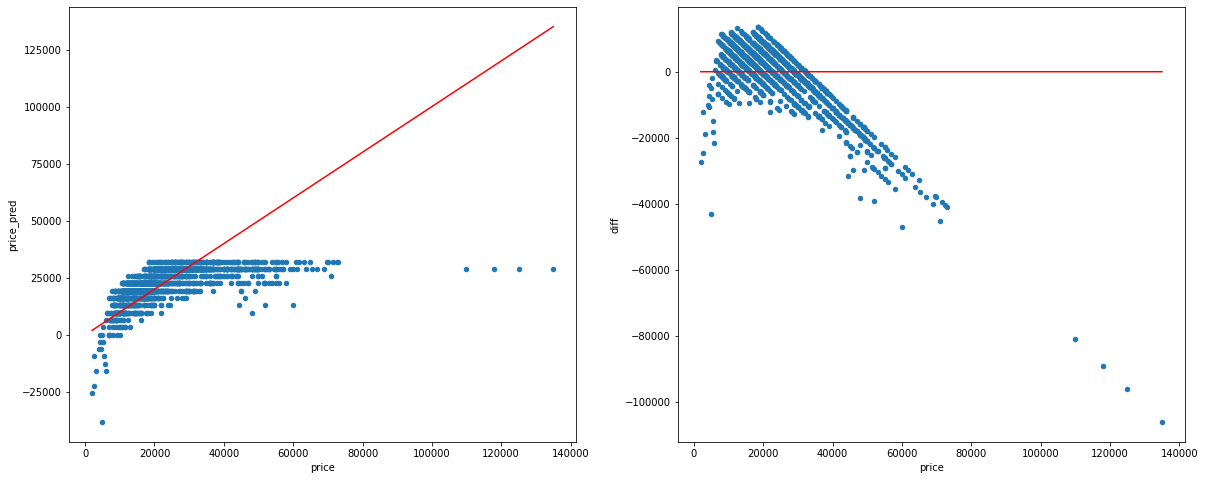

In [ ]:
y_test_preds_lm_year = model_linear_1_var.predict(X_test[["year"]])

plot_preds_diff(y_test, y_test_preds_lm_year)

Es evidente que el modelo tiene muchos sesgos. Representamos gráficamente el precio en función del año en el conjunto de test. Comentar dos cosas de esta figura: el año está estandarizado, los puntos azules se corresponden a las observaciones del conjunto de test y la línea roja a lo que predice el modelo:

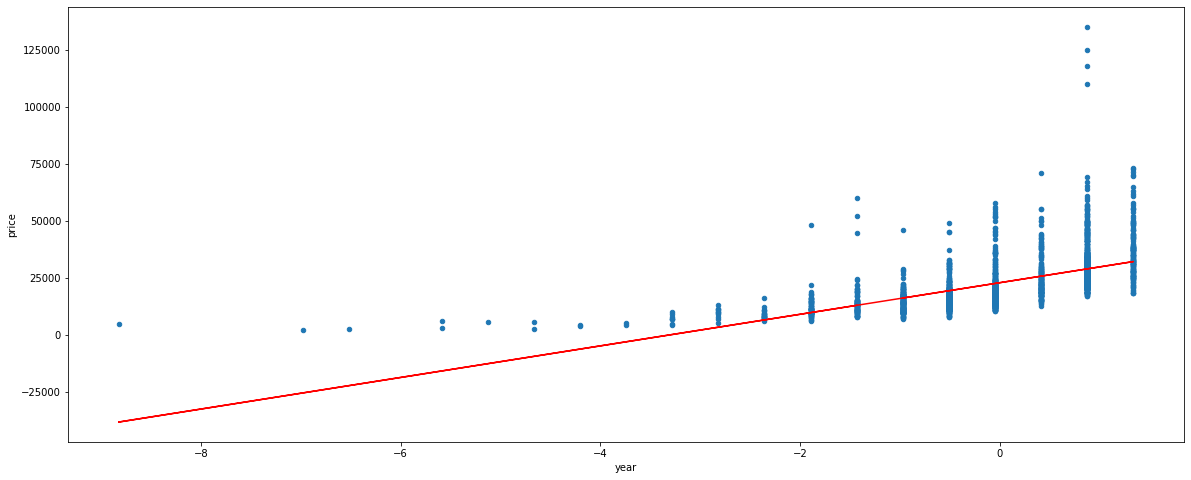

In [ ]:
df_linear_preds = pd.concat(objs=[X_test["year"], y_test, pd.Series(y_test_preds_lm_year, index=X_test.index, name="price_pred")], axis=1)

fig, ax = plt.subplots(1)
fig.set_size_inches(20, 8)
df_linear_preds.plot(kind="scatter", x="year", y="price", ax=ax);
df_linear_preds.plot(x="year", y="price_pred", ax=ax, color="red", legend=False);

Es evidente que el modelo está muy lejos de ser lo suicientemente complejo. Posibles mejoras serían incluir más grado o probar con alguna otra variable. En cualquier caso, pasamos a considerar varias variables.

Guardamos las predicciones:

In [ ]:
y_test_preds_linear_1 = model_linear_1_var.predict(X_test[["year"]])

## Regresión lineal con varias variables

### Polinomios de primer grado

Para empezar, entrenamos un modelo lineal con todas las variables considerando solo grado uno:

In [ ]:
model_linear_m_var = GridSearchCV(estimator=linear_model.LinearRegression(),
                                  param_grid={},
                                  cv=shuffle_split,
                                  refit=True,
                                  verbose=1,
                                  n_jobs=-1,
                                  return_train_score=True,
                                  scoring="neg_mean_squared_error"
                                 )

model_linear_m_var.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Veamos el rendimiento en entrenamiento:

In [ ]:
print_metrics(model_linear_m_var, X_train, y_train)

El ratio entre el mae y la mediana del precio es: 0.16183967689613066.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.22384265459662916
El coeficiente R2 es: 0.8089090392884959


Y en test:

In [ ]:
print_metrics(model_linear_m_var, X_test, y_test)

El ratio entre el mae y la mediana del precio es: 0.1604941688763298.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.22246643445870085
El coeficiente R2 es: 0.8095838427634737


Vemos que los resultados mejoran sustancialmente respecto al caso de una única variable. Además, tampoco estamos sobreajustando.

Mostremos ahora las predicciones en función de los precios, así como las diferencias:

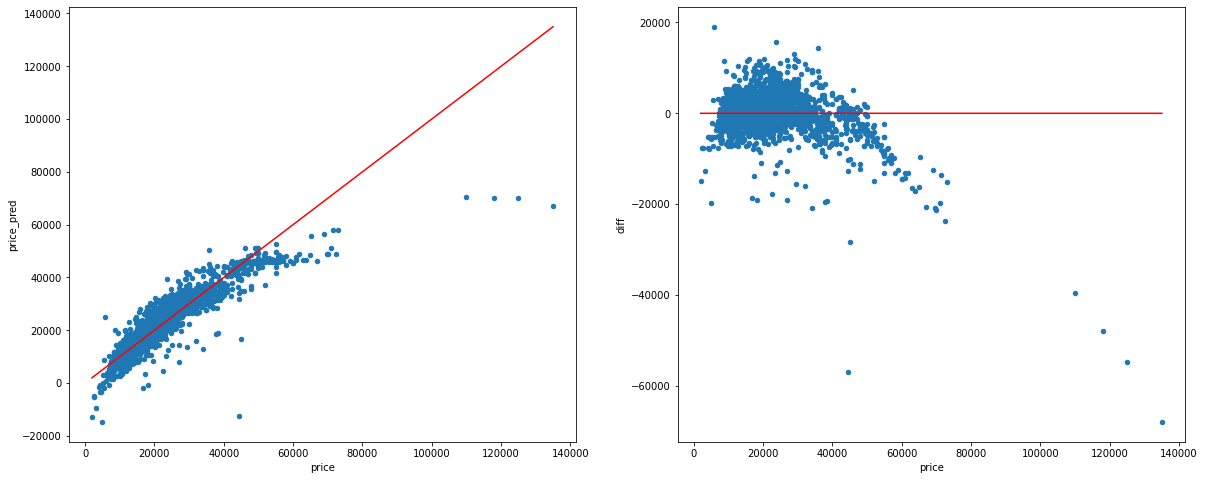

In [ ]:
plot_preds_diff(y_test, model_linear_m_var.predict(X_test))

Vemos dos patrones interesantes:

1. Primero, igual que en los modelos tipo árbol, aunque de forma más acusada, para precios altos el modelo falla a la baja.
2. Para precios por debajo de 80000 libras, tenemos dos sectores: para precios muy altos o muy bajos dentro de este rango, el modelo subestima los precios; por contra, para valores intermedios (en torno a 20000-30000 libras), el modelo sobrestima los precios.

Recordemos que el modelo consiste en:

$$
\text{price} = b + a_1 \text{engineSize} + a_2 \text{mileage} + a_3 \text{model} + \dots
$$

Es por esto que podemos estudiar la relevancia de variables a partir de la magnitud de los coeficientes. Veámoslo. Estudiamos primero la relevancia de las variables "model", "mileage", "tax", "year", "mpg" y "engineSize" y por otro la de las "one-hot encoded". Lo hacemos así porque las primeras están estandarizadas y las segundas toman como valores 1's y 0's, de tal forma que sus escalas son diferentes y no se pueden comparar dairectamente sus valores.

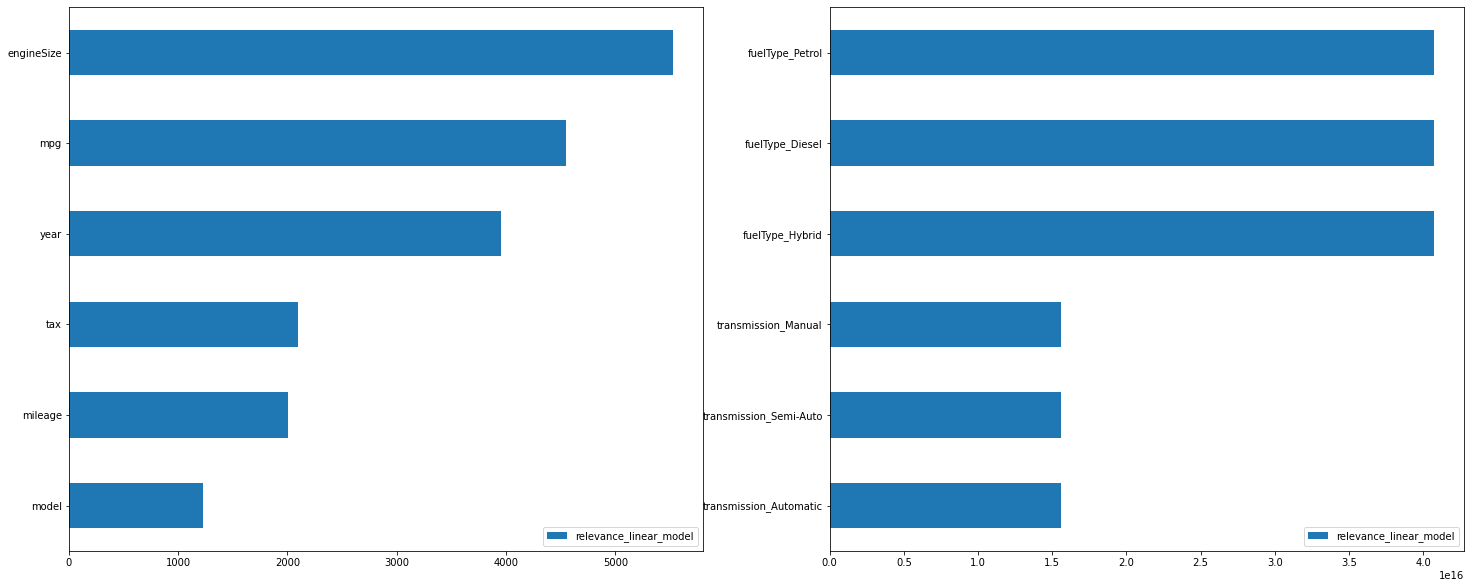

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(25, 10)

df_feature_relevance = pd.DataFrame(data={"columns": X_train.columns.tolist(), "relevance_linear_model": np.abs(model_linear_m_var.best_estimator_.coef_)})
df_feature_relevance.reset_index(drop=True, inplace=True)

df_feature_relevance_num = df_feature_relevance.loc[df_feature_relevance["columns"].isin(["engineSize", "mpg", "year", "tax", "mileage", "model"])]
df_feature_relevance_num.sort_values(by="relevance_linear_model", ascending=True, inplace=True)
plot_feature_relevance_num = df_feature_relevance_num.plot(kind="barh", ax = axes[0])
plot_feature_relevance_num.set_yticklabels(df_feature_relevance_num["columns"]);

df_feature_relevance_ohe = df_feature_relevance.loc[df_feature_relevance["columns"].isin(["fuelType_Diesel", "fuelType_Petrol", "fuelType_Hybrid", "transmission_Manual", "transmission_Semi-Auto", "transmission_Automatic"])]
df_feature_relevance_ohe.sort_values(by="relevance_linear_model", ascending=True, inplace=True)
plot_feature_relevance_ohe = df_feature_relevance_ohe.plot(kind="barh", ax = axes[1])
plot_feature_relevance_ohe.set_yticklabels(df_feature_relevance_ohe["columns"]);


Entre las variables puramente numéricas, vemos que, si bien el orden ha cambiado algo, "engineSize", "mpg" y "year" son las más relevantes, como ya vimos en los análisis con Random Forest y XGBoost. Por otra parte, de las variables categóricas con "one-hot encoding", aquí vemos que el tipo de combustible tiene más relevancia que el tipo de transmisión. Esto último no era demasiado concluyente en los análisis previos.

### Polinomios de segundo grado

Una vía de mejora es introducir polinomios de más alto grado. En base a las representaciones gráficas de la variable objetivo frente a las distintas variables numéricas, probamos a poner términos de orden 2 para el año, el consumo ("mpg") y la distancia recorrida ("mileage"):

In [ ]:
X_train_degree_2 = X_train.copy()
X_test_degree_2 = X_test.copy()

pf_year = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_degree_2["year_2"] = pf_year.fit_transform(X_train[["year"]])[:, 1]
X_test_degree_2["year_2"] = pf_year.transform(X_test[["year"]])[:, 1]

pf_mpg = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_degree_2["mpg_2"] = pf_year.fit_transform(X_train[["mpg"]])[:, 1]
X_test_degree_2["mpg_2"] = pf_year.transform(X_test[["mpg"]])[:, 1]

pf_mileage = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_degree_2["mileage_2"] = pf_year.fit_transform(X_train[["mileage"]])[:, 1]
X_test_degree_2["mileage_2"] = pf_year.transform(X_test[["mileage"]])[:, 1]

Ahora hay que estandarizar estas nuevas variables:

In [ ]:
sc_2 = StandardScaler()
list_numerical_variables_2 = ["year_2", "mpg_2", "mileage_2"]

np_X_train_2 = sc_2.fit_transform(X_train_degree_2[list_numerical_variables_2])
np_X_test_2 = sc_2.transform(X_test_degree_2[list_numerical_variables_2])

X_train_degree_2[list_numerical_variables_2] = np_X_train_2
X_test_degree_2[list_numerical_variables_2] = np_X_test_2

Entrenamos:

In [ ]:
model_linear_m_var_2 = GridSearchCV(estimator=linear_model.LinearRegression(),
                                    param_grid={},
                                    cv=shuffle_split,
                                    refit=True,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True,
                                    scoring="neg_mean_squared_error"
                                    )

model_linear_m_var_2.fit(X_train_degree_2, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Mostramos las métricas una vez más en entrenamiento:

In [ ]:
print_metrics(model_linear_m_var_2, X_train_degree_2, y_train)

El ratio entre el mae y la mediana del precio es: 0.15972658876642787.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.21609464241357557
El coeficiente R2 es: 0.8219088050155334


Y test:

In [ ]:
print_metrics(model_linear_m_var_2, X_test_degree_2, y_test)

El ratio entre el mae y la mediana del precio es: 0.1592149335568213.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.21763738140255037
El coeficiente R2 es: 0.8177608036229471


Vemos que hemos mejorado ligeramente los resultados, además de que seguimos sin tener sobreajuste. Veamos una vez más las predicciones frente a los precios reales:

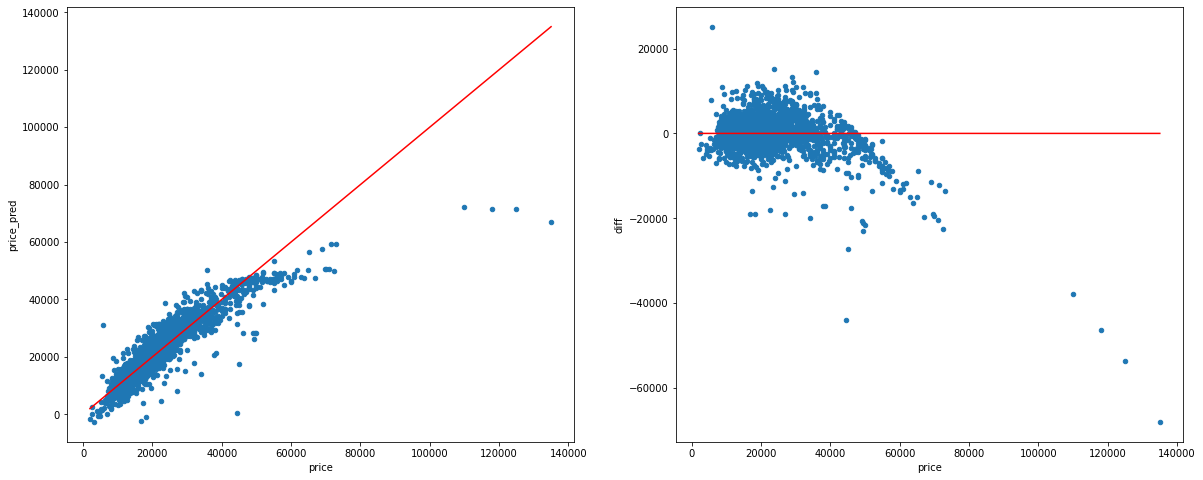

In [ ]:
plot_preds_diff(y_test, model_linear_m_var_2.predict(X_test_degree_2))

Seguimos teniendo los mismos sesgos. Podríamos tratar de mejorar esto introduciendo más términos, como polinomios de mayor grado o términos cruzados del tipo "year" * "mileage", por ejemplo.

Guardamos las predicciones:

In [ ]:
y_test_preds_linear_m = model_linear_m_var_2.predict(X_test_degree_2)

### Selección de variables

En el análisis exploratorio del principio vimos que, a prior, el tipo de combustible no debería tener demasiado impacto en el rendimiento. Además, en el tipo de transmisión hemos visto que los cambios automático y semi apenas son diferentes, así que podemos quedarnos únicamente con la columna "transmission_Manual", que nos distingue si el cambio es manual (1) o si es automático o semi (0).

In [ ]:
model_linear_m_var_2_vs = GridSearchCV(estimator=linear_model.LinearRegression(),
                                    param_grid={},
                                    cv=shuffle_split,
                                    refit=True,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True,
                                    scoring="neg_mean_squared_error"
                                    )

X_train_vs = X_train_degree_2.drop(columns=['fuelType_Diesel',
                                            'fuelType_Hybrid',
                                            'fuelType_Petrol',
                                            'transmission_Semi-Auto',
                                            'transmission_Automatic'])

X_test_vs = X_test_degree_2.drop(columns=['fuelType_Diesel',
                                            'fuelType_Hybrid',
                                            'fuelType_Petrol',
                                            'transmission_Semi-Auto',
                                            'transmission_Automatic'])

model_linear_m_var_2_vs.fit(X_train_vs, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Veamos los resultados:

In [ ]:
print_metrics(model_linear_m_var_2_vs, X_train_vs, y_train)

El ratio entre el mae y la mediana del precio es: 0.15961815993543055.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.21652901168818992
El coeficiente R2 es: 0.8211921274537559


In [ ]:
print_metrics(model_linear_m_var_2_vs, X_test_vs, y_test)

El ratio entre el mae y la mediana del precio es: 0.15908224638838564.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.2187351288997442
El coeficiente R2 es: 0.8159177641043676


Vemos que las métricas son, esencialmente, iguales a las del modelo anterior, que contaban con estas variables. De esta forma concluimos que, al menos para el modelo lineal, estas variables son completamente prescindibles. Recordemos que esto encaja con el análisis previo de relevancia de variables realizado con el Random Forest.

### Reducción de dimensionalidad: PCA

Como hemos visto en el análisis exploratorio de las variables numéricas, algunas de ellas están correlacionadas. Es por esto que, en lo que sigue, probamos a sustituir estas por sus PCA.

Para este modelo partiremos de la tabla de datos del modelo anterior, pero prescindimos de las columnas de más alto grado, ya que estas se derivaban de columnas a las que ahora les vamos a aplicar PCA:

In [ ]:
X_train_pca = X_train_vs.drop(columns=["year_2", "mpg_2", "mileage_2"])
X_test_pca = X_test_vs.drop(columns=["year_2", "mpg_2", "mileage_2"])

En primer lugar, cambiamos "year" y "mileage" por su PCA con una componente:

In [ ]:
pca_ym, X_year_mileage = do_pca(X=X_train_pca[["year", "mileage"]], n=1)
X_train_pca["year_mileage_1"] = X_year_mileage
X_test_pca["year_mileage_1"] = pca_ym.transform(X_test_pca[["year", "mileage"]])

Una vez introducida la nueva variable, prescindimos de "year" y "mileage":

In [ ]:
X_train_pca.drop(columns=["year", "mileage"], inplace=True)
X_test_pca.drop(columns=["year", "mileage"], inplace=True)

Ahora introducimos el PCA de "tax", "mpg" y "engineSize" con 2 componentes:

In [ ]:
pca_tme, X_tax_mpg_engineSize = do_pca(X=X_train_pca[["tax", "mpg", "engineSize"]], n=2)
X_train_pca["tax_mpg_engineSize_1"] = X_tax_mpg_engineSize[:,0]
X_train_pca["tax_mpg_engineSize_2"] = X_tax_mpg_engineSize[:,1]

X_test_pca["tax_mpg_engineSize_1"] = ""
X_test_pca["tax_mpg_engineSize_2"] = ""
np_tme_pca = pca_tme.transform(X_test_pca[["tax", "mpg", "engineSize"]])
X_test_pca["tax_mpg_engineSize_1"] = np_tme_pca[:,0]
X_test_pca["tax_mpg_engineSize_2"] = np_tme_pca[:,1]

Volvemos a precindir de las columnas que hemos usado para el PCA:

In [ ]:
X_train_pca.drop(columns=["tax", "mpg", "engineSize"], inplace=True)
X_test_pca.drop(columns=["tax", "mpg", "engineSize"], inplace=True)

En principio, sería conveniente estandarizar estas columnas. Antes de hacerlo, veamos su desviación estándar y media:

In [ ]:
def print_mean_std(X, col):
    print("La media de la variable {} es: {}".format(col, X[col].mean()))
    print("La desviación estándar de la variable {} es: {}".format(col, X[col].std()))

print_mean_std(X_train_pca, "year_mileage_1")
print_mean_std(X_train_pca, "tax_mpg_engineSize_1")
print_mean_std(X_train_pca, "tax_mpg_engineSize_2")

La media de la variable year_mileage_1 es: -6.6608177713625515e-18
La desviación estándar de la variable year_mileage_1 es: 1.3367747288628786
La media de la variable tax_mpg_engineSize_1 es: 4.4960519956697225e-17
La desviación estándar de la variable tax_mpg_engineSize_1 es: 1.3929386632780165
La media de la variable tax_mpg_engineSize_2 es: -3.5801895521073715e-17
La desviación estándar de la variable tax_mpg_engineSize_2 es: 0.8326763327284189


Vemos que las variables ya están prácticamente estandarizadas, así que no hace falta estandarizarlas.

Entrenamos un primer modelo así:

In [ ]:
model_linear_pca = GridSearchCV(estimator=linear_model.LinearRegression(),
                                    param_grid={},
                                    cv=shuffle_split,
                                    refit=True,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True,
                                    scoring="neg_mean_squared_error"
                                    )

model_linear_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
print_metrics(model_linear_pca, X_train_pca, y_train)

El ratio entre el mae y la mediana del precio es: 0.1837136149480024.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.2515506505754473
El coeficiente R2 es: 0.758673319877261


In [ ]:
print_metrics(model_linear_pca, X_test_pca, y_test)

El ratio entre el mae y la mediana del precio es: 0.17910258414407357.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.2432664251806815
El coeficiente R2 es: 0.7723125179852577


Vemos que la precisión ha bajado algo respecto al caso de grado uno. Veamos las predicciones frente a los valores reales:

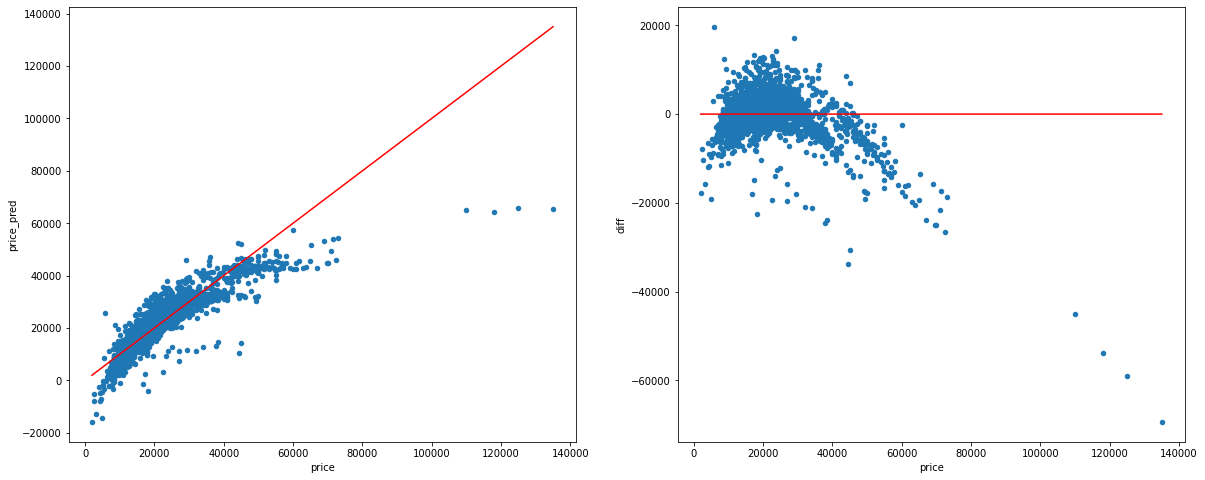

In [ ]:
plot_preds_diff(y_test, model_linear_pca.predict(X_test_pca))

De nuevo encontramos el mismo patrón.

Para mejorar estos resultados, introducimos de nuevo variables de mayor grado, en este caso de las variables "year_mileage_1", "tax_mpg_engineSize_1" y "tax_mpg_engineSize_2":

In [ ]:
X_train_pca_degree_2 = X_train_pca.copy()
X_test_pca_degree_2 = X_test_pca.copy()

pf_ym = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_pca_degree_2["year_mileage_1_sq"] = pf_ym.fit_transform(X_train_pca_degree_2[["year_mileage_1"]])[:, 1]
X_test_pca_degree_2["year_mileage_1_sq"] = pf_ym.transform(X_test_pca_degree_2[["year_mileage_1"]])[:, 1]

pf_tme_1 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_pca_degree_2["tax_mpg_engineSize_1_sq"] = pf_tme_1.fit_transform(X_train_pca_degree_2[["tax_mpg_engineSize_1"]])[:, 1]
X_test_pca_degree_2["tax_mpg_engineSize_1_sq"] = pf_tme_1.transform(X_test_pca_degree_2[["tax_mpg_engineSize_1"]])[:, 1]

pf_tme_2 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_pca_degree_2["tax_mpg_engineSize_2_sq"] = pf_tme_2.fit_transform(X_train_pca_degree_2[["tax_mpg_engineSize_2"]])[:, 1]
X_test_pca_degree_2["tax_mpg_engineSize_2_sq"] = pf_tme_2.transform(X_test_pca_degree_2[["tax_mpg_engineSize_2"]])[:, 1]

Estandarizamos las variables cuadráticas:

In [ ]:
sc_2_pca = StandardScaler()
list_numerical_variables_2_pca = ["year_mileage_1_sq", "tax_mpg_engineSize_1_sq", "tax_mpg_engineSize_2_sq"]

np_X_train_2_pca = sc_2.fit_transform(X_train_pca_degree_2[list_numerical_variables_2_pca])
np_X_test_2_pca = sc_2.transform(X_test_pca_degree_2[list_numerical_variables_2_pca])

X_train_pca_degree_2[list_numerical_variables_2_pca] = np_X_train_2_pca
X_test_pca_degree_2[list_numerical_variables_2_pca] = np_X_test_2_pca

Entrenamos:

In [ ]:
model_linear_pca_2 = GridSearchCV(estimator=linear_model.LinearRegression(),
                                    param_grid={},
                                    cv=shuffle_split,
                                    refit=True,
                                    verbose=1,
                                    n_jobs=-1,
                                    return_train_score=True,
                                    scoring="neg_mean_squared_error"
                                    )

model_linear_pca_2.fit(X_train_pca_degree_2, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=None, train_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

Veamos las métricas en entrenamiento y test:

In [ ]:
print_metrics(model_linear_pca_2, X_train_pca_degree_2, y_train)

El ratio entre el mae y la mediana del precio es: 0.1740974601112421.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.22836744370189627
El coeficiente R2 es: 0.8011054743790265


In [ ]:
print_metrics(model_linear_pca_2, X_test_pca_degree_2, y_test)

El ratio entre el mae y la mediana del precio es: 0.16607093156106903.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.21241833039500682
El coeficiente R2 es: 0.8263963748257849


De nuevo, etamos hablando de métricas similares en entrenamiento y test, así que no tenemos sobreajuste.

Mostramos las predicciones en función de los valores reales de nuevo:

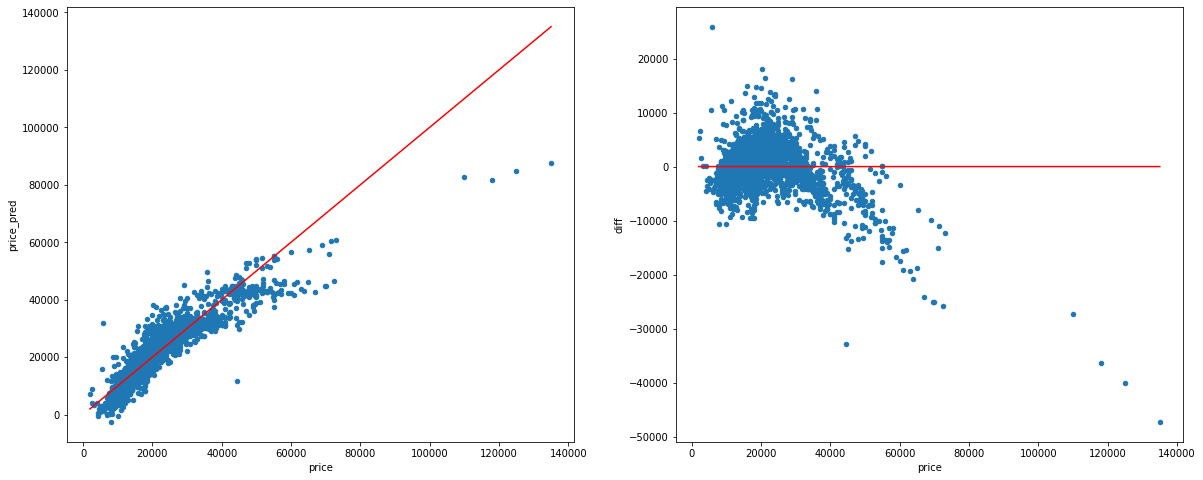

In [ ]:
plot_preds_diff(y_test, model_linear_pca_2.predict(X_test_pca_degree_2))

Si bien cualititativamente tenemos lo mismo, se ha mitigado un poco el problema de los precios altos.

En resumidas cuentas, comparando los resultados en test con los propios para el caso sin PCA y con grado dos, vemos que tenemos una métrica muy similar (ligeramente peor ahora en *mae* y *mse*, pero mejor para $R^2$), además de que la representación gráfica de las predicciones es bastante similar cualitativamente. Por ende, con un modelo más simple, vemos que obtenemos unos resultados igual de buenos. Para el caso que nos atañe esto no es demasiado relevante, ya que los tiempos de ejecución para entrenar modelos y predecir son de décimas de segundo, pero hay ocasiones en las que estos tiempos suben mucho, de tal forma que encontrar modelos más simples que sean capaces de dar rendimientos igual de buenos en mucho menos tiempo es crítico.

# Comparación entre modelos

Igual que hicimos en el caso de clasificación, comparamos los modelos obtenidos entre sí.

También compararemos con dos modelos triviales (la media y la mediana de los precios en el conjunto de entrenamiento) para así poner en valor lo que obtienen los modelos construidos con algoritmos supervisados.

Usaremos como métricas:
* 1-mae
* 1-mse
* $R^2$

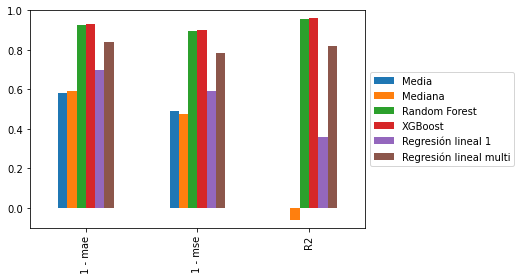

In [ ]:
df_results = pd.DataFrame([], index=["1 - mae", "1 - mse", "R2"])

def get_mae_mean_R2(y, y_preds):
    return [1 - mean_absolute_error(y, y_preds) / y.median(),
            1 - np.sqrt(mean_squared_error(y, y_preds)) / y.mean(),
            r2_score(y, y_preds)]

y_preds_mean = np.repeat(y_train.mean(), len(y_test)).tolist()
y_preds_median = np.repeat(y_train.median(), len(y_test)).tolist()

df_results["Media"] = get_mae_mean_R2(y_test, y_preds_mean)
df_results["Mediana"] = get_mae_mean_R2(y_test, y_preds_median)
df_results["Random Forest"] = get_mae_mean_R2(y_test, y_test_preds_RF)
df_results["XGBoost"] = get_mae_mean_R2(y_test, y_test_preds_xgb)
df_results["Regresión lineal 1"] = get_mae_mean_R2(y_test, y_test_preds_linear_1)
df_results["Regresión lineal multi"] = get_mae_mean_R2(y_test, y_test_preds_linear_m)

f = plt.figure()

df_results.plot(kind='bar', ax=f.gca(), ylim=(-0.1, 1))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Como vemos, los modelos construidos con algoritmos supervisados son sistemáticamente mejores que la media y la mediana.

A modo de curiosidad, notar que $R^2$ es prácticamente 0 para la media. Si nos fijamos en la definición de $R^2$, que recuperamos aquí:

$$
R^2 = 1 - \frac{\sum_{i=1}^m(y_i - \hat{y}_i)^2}{\sum_{i=1}^m(y_i - \bar{y})^2},
$$

esto es totalmente natural. Por otra parte, para el caso de la mediana, $R^2$ se hace negativo. Esto suele chocar, ya que tendemos a trabajar con métricas que tienen valores acotados entre 0 y 1. Sin embargo, si acudimos a la definición de $R^2$, esto es perfectamente posible. Simplemente significa que, en lo que respecta a los errores cuadráticos, el modelo de la mediana es incluso peor que la media.

Por otra parte, vemos que el XGBoost es el modelo con mejor rendimiento según todas las métricas, seguido muy de cerca por el Random Forest. Además, la regresión lineal con una variable está netamente por debajo. Finalmente, el caso de la regresión lineal multivariable, que es en particular el modelo en el que se han considerado términos de grado 2 para "year", "mpg" y "mileage", mejora ampliamente al modelo lineal de una variable y no está demasiado lejos del Random Foresst y del XGBoost.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Supongamos que tienes un dataset con una columna categórica
data = pd.DataFrame({
    'color': ['rojo', 'azul', 'verde', 'azul', 'rojo', 'verde', 'verde', 'azul'],
    'valor': [10, 20, 30, 40, 50, 60, 70, 80]
})

# 1. Dividir el dataset en entrenamiento y prueba
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# 2. Calcular las frecuencias en el conjunto de entrenamiento
freq_map = X_train['color'].value_counts(normalize=True).to_dict()

# 3. Aplicar Frequency Encoding al conjunto de entrenamiento
X_train['color_freq'] = X_train['color'].map(freq_map)

# 4. Aplicar las mismas frecuencias al conjunto de prueba
X_test['color_freq'] = X_test['color'].map(freq_map)

# Mostrar los resultados
print("Conjunto de entrenamiento:")
print(X_train)

print("\nConjunto de prueba:")
print(X_test)

Conjunto de entrenamiento:
   color  valor  color_freq
0   rojo     10    0.333333
7   azul     80    0.333333
2  verde     30    0.333333
4   rojo     50    0.333333
3   azul     40    0.333333
6  verde     70    0.333333

Conjunto de prueba:
   color  valor  color_freq
1   azul     20    0.333333
5  verde     60    0.333333
